In [1]:
# Initial imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import requests
import datetime
from datetime import datetime, timedelta, date
from dateutil.parser import parse
import matplotlib.pyplot as plt

#Alpaca API imports
import alpaca_trade_api as tradeapi

#Twitter API imports
import tweepy as tw

# NLP & Sentiment imports
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

from dotenv import load_dotenv
load_dotenv()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Kris/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
############################################################
"""
    Authenticates the Alpaca API and Twitter
    Returns a pass/fail statement
"""
############################################################  
    
# Setting twitter access and api keys
bearer_token = os.getenv("TWITTER_BEARER_TOKEN")
consumer_key= os.getenv("TWITTER_API_KEY")
consumer_secret= os.getenv("TWITTER_SECRET_KEY")
access_token= os.getenv("TWITTER_ACCESS_TOKEN")
access_token_secret= os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

# authentication for twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# test authentication
try:
    twitter_api.verify_credentials()
    auth = "Twitter Authentication Verified"
except:
    auth = "Error During Twitter Authentication"
    
print(auth)

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

Twitter Authentication Verified


In [66]:
############################################################
"""
   Reads in a CSV of data and returns a data frame.
"""
############################################################

def read_csv(path):

    csvpath = Path(path)
    df = pd.read_csv(csvpath, parse_dates=True, index_col="date", infer_datetime_format=True)
    df.drop(columns=["Unnamed: 0", "tweet","positive","negative", "neutral"], inplace=True)
    avg_df = df.groupby(pd.Grouper(level=0, freq='15min')).mean().dropna()

    
    return avg_df

############################################################
"""
    Cleans the tweets and removes the included url
    
    Note: Did not use this function in the end, as VADER
    does better with punctuation, emojis, and CAPS.
"""
############################################################

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())



############################################################
"""
    Sentiment calculation based on compound score
"""
############################################################

def get_normalized(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.04:  # Positive
        result = 1
    elif score <= -0.04:  # Negative
        result = -1

    return result


############################################################
"""
    Function that pulls stock data from a given ticker and timeframe.
"""
############################################################

def daily_returns(ticker, timeframe):
        
    # Set current date and the date from one month ago using the ISO format
    current_date = pd.Timestamp.now(tz="America/New_York").isoformat()
    past_date = pd.Timestamp("2021-01-01 00:00", tz="America/New_York").isoformat()

    # Get 4 weeks worth of historical data for AAPL
    df = alpaca_api.get_barset(
        ticker,
        timeframe,
        limit=None,
        start=past_date,
        end=current_date,
        after=None,
        until=None,
    ).df
        
    return df



############################################################
"""
    Twitter: Scrape Tweets and Analyze Sentiment
"""
############################################################

def twitter_sentiment(search_words, date_since, items):
       
    # Initialize the VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # initializing the tweets dataframe
    df = []
    
    # adding retweet filter to search words
    search_words = search_words + " -filter:retweets"
    
    # Fetch top tweets/hastags for given ticker
    tweets = tw.Cursor(twitter_api.search,
              q=search_words,
              lang="en",
              since=date_since
                    ).items(items)
    
    for tweet in tweets:
    
        tweet_fetched = tweet.text 
        #Clean text of tweets
        #remove_url(tweet.text)

        # Get date of tweet
        tweet_date = pd.Timestamp(tweet.created_at, tz="America/New_York").isoformat()
        
        try:
            sentiment = analyzer.polarity_scores(tweet_fetched)
            compound = sentiment["compound"]
            #pos = sentiment["pos"]
            #neu = sentiment["neu"]
            #neg = sentiment["neg"]
        
            df.append({
                "date": tweet_date,
                "tweet": tweet_fetched,
                "compound": compound,
                #"positive": pos,
                #"negative": neg,
                #"neutral": neu
            
            })
        
        except AttributeError:
            pass
    
    df = pd.DataFrame(df)
    
    return df



############################################################
"""
    get_twitter_sentiment(search_words):
    Takes 1 argument, word(s) to search tweets for.
    
    Scrapes Twitter for given search words in tweet
    Calculates compound sentiment with VADER sentiment analyzer on each tweet
    Calculates average compound sentiment score each 1 hour
    Normalizes average hourly VADER compound score
    Returns Average Hourly Sentiment Dataframe with Columns: 
"""
############################################################

def get_avg_twitter_sentiment(search_words):

    # tweepy variables
    search_words = search_words
    date_since = "2021-01-01"
    items = 500

    # call the twitter sentiment function and return a dataframe
    tweets_df = twitter_sentiment(search_words, date_since, items)

    # Changes the date column to proper datetime format
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    
    # Code below didn't produce proper result downstream - saving for reference
    # Creates datetime object and outputs only the Date and Hour for each tweet
    # tweets_df['date'] = tweets_df['date'].apply(lambda x: pd.Timestamp(x).strftime('%m-%d-%Y %H'))

    # Save raw tweets dataframe to csv
    # Next steps, 
        # 1. Scan folder to see if csv file of user input ticker exists
        # 2. Create the new filename as a user input variable if csv does not exist
        # 3. If csv file already exists, open, append new date rows, save, close.
    # tweets_df.to_csv(r'C:\Users\Kris\Documents\ucb_fintech\Homework\Project2\tweets\msft_tweets.csv')
    
    # Grouping the tweets by Hour and taking their average Hourly sentiment
    avg_sentiment = tweets_df.groupby(pd.Grouper(key='date', freq='H')).mean().dropna()
    
    # Get the normalized sentiment score of -1, 0, 1
    avg_sentiment["normalized"] = avg_sentiment["compound"].apply(lambda x : get_normalized(x))
    
    return avg_sentiment


############################################################
"""
    get_ticker_sentiment(ticker):
    Takes 1 argument, ticker to search tweets for.
    
    Scrapes Twitter for given search words.
    Calculates compound sentiment with VADER sentiment analyzer 
    Normalizes VADER compound score
    Returns Average Daily Sentiment Dataframe with Columns: 
"""
############################################################

def get_ticker_returns(ticker, timeframe):
    
    # alpaca api variables
    ticker = ticker
    timeframe = timeframe

    # call the alpaca api and return a dataframe of daily returns
    daily_df = daily_returns(ticker, timeframe)

    # Drop Outer Table Level and drop extra columns
    daily_df = daily_df.droplevel(axis=1, level=0)
    daily_df = daily_df.drop(columns=["open", "high", "low", "volume"])

    # Get the percent change of the closing prices, drop any NA rows, and reset the index
    # daily_df["percent_change"] = daily_df.pct_change().dropna()
    returns_df = daily_df.pct_change().dropna()

    # Grouping the tweets by Hour and taking their average Hourly sentiment
    # avg_returns = returns_df.groupby(pd.Grouper(level=0, freq='H')).mean().dropna()
    
    return returns_df



############################################################
"""
    combine_sentiment_with_close(avg_hourly_returns, avg_hourly_sentiment):
    Takes 2 arguments: the two dataframes to combine
"""
############################################################

def combine_sentiment_with_close(avg_hourly_sentiment, avg_hourly_returns):

    # Combines the average hourly Twitter sentiment dataframe with the hourly percent change dataframe
    combined_df = avg_hourly_returns.join(avg_hourly_sentiment).dropna()
    
    return combined_df



############################################################
"""
    main_function:
    Defines the main function.
    1 argument: search word to search twitter and stock prices.
"""
############################################################

def main_function(twitter_search_word, ticker, timeframe):
    
    # calling csv function to read in stored data
    # twitter_sentiment = read_csv("tweets/msft_tweets.csv")
    
    twitter_sentiment = get_avg_sentiment(twitter_search_word)
    percent_change = get_ticker_returns(ticker, timeframe)
    combined_df = combine_sentiment_with_close(twitter_sentiment, percent_change)
    
    
    return combined_df

In [58]:
twitter_search_word = "microsoft" # to be updated to %store -r search_word
ticker = "MSFT" # to be updated to %store -r ticker
timeframe = "5Min"


combined_df = main_function(twitter_search_word, ticker, timeframe)
combined_df

KeyboardInterrupt: 

In [67]:
#reading in a prepping the training data using a frequency of 15-minute time intervals
# pd.set_option("display.max_rows", 50, "display.max_columns", 50)

twitter_search_word = "microsoft" 
ticker = "MSFT" 
timeframe = "5Min"
freq = "5min"

csvpath = Path("tweets/msft_tweets.csv")
df = pd.read_csv(csvpath, parse_dates=True, index_col="date", infer_datetime_format=True)
df.drop(columns=["Unnamed: 0", "tweet","positive","negative", "neutral"], inplace=True)
avg_df = df.groupby(pd.Grouper(level=0, freq=freq)).mean().dropna()

percent_change = get_ticker_returns(ticker, timeframe)
combined_df = percent_change.join(avg_df).dropna()
#combined_df.sort_values(by="time", axis=0, ascending=False)
combined_df

,close,compound
time,,
2021-01-11 13:40:00+00:00,-0.007879,0.220200
2021-01-11 13:55:00+00:00,-0.001148,-0.038600
2021-01-11 14:15:00+00:00,0.000919,0.726900
2021-01-11 14:20:00+00:00,-0.000918,0.226933
2021-01-11 14:30:00+00:00,-0.000873,0.115350
...,...,...
2021-01-15 20:40:00+00:00,-0.001826,0.025740
2021-01-15 20:45:00+00:00,0.000375,0.386329
2021-01-15 20:50:00+00:00,-0.001454,0.186680


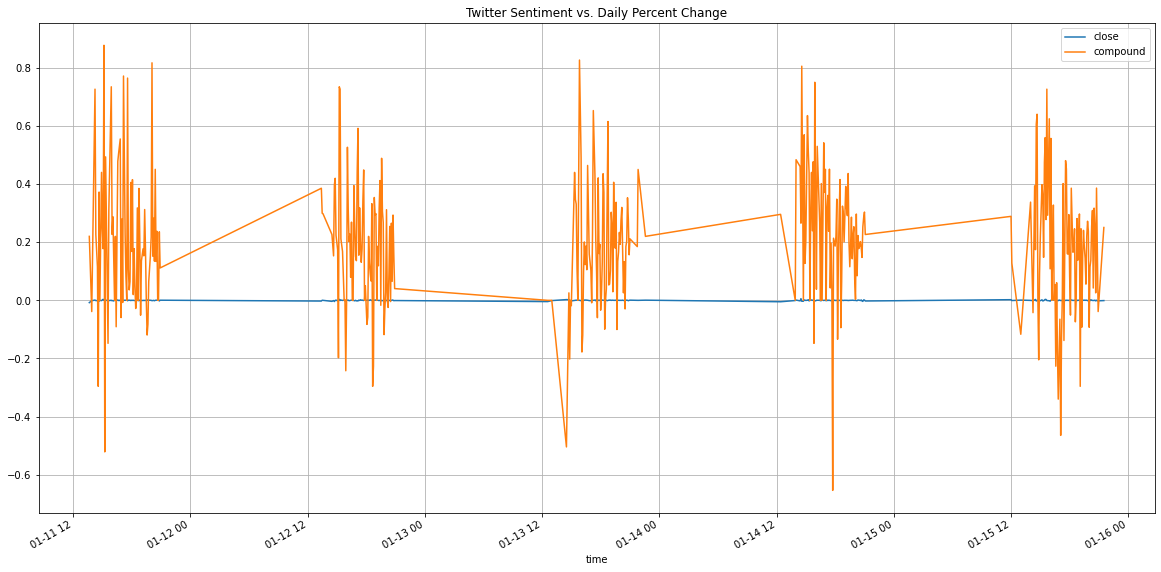

In [68]:
combined_df.plot(
    y=["close","compound"],
    kind="line",
    title= "Twitter Sentiment vs. Daily Percent Change",
    figsize= (20,10),
    grid=True,
);

In [69]:
# Get descriptive stats from the DataFrame
combined_df.describe()

,close,compound
count,388.000000,388.000000
mean,-0.000095,0.193555
std,0.001225,0.224614
min,-0.007879,-0.654150
25%,-0.000674,0.037633
50%,0.000000,0.186740
75%,0.000513,0.313176
max,0.005792,0.877900


In [70]:
# Correlate the twitter sentiment to returns
combined_df.corr().style.background_gradient()

,close,compound
close,1.000000,-0.057820
compound,-0.057820,1.000000


In [89]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    
    `df`: The original DataFrame with the time series data.
    `window`: The window size in days of previous closing prices that will be used for the prediction.
    `feature_col_number`: The column number from the original DataFrame where the features are located.
    `target_col_number`: The column number from the original DataFrame where the target is located.
  
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [90]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 1
target_column = 0

X, y = window_data(combined_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 0.2202     -0.0386      0.7269      0.22693333  0.11535   ]
 [-0.0386      0.7269      0.22693333  0.11535    -0.296     ]
 [ 0.7269      0.22693333  0.11535    -0.296       0.3728    ]
 [ 0.22693333  0.11535    -0.296       0.3728      0.        ]
 [ 0.11535    -0.296       0.3728      0.          0.4404    ]] 

y sample values:
[[ 2.41479233e-03]
 [-3.05136853e-03]
 [-4.60256823e-05]
 [-9.87915269e-04]
 [ 1.49483706e-03]]


In [91]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [92]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [93]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.57070592]
  [0.40178193]
  [0.90143925]
  [0.5751009 ]
  [0.5022682 ]]

 [[0.40178193]
  [0.90143925]
  [0.5751009 ]
  [0.5022682 ]
  [0.23377174]]

 [[0.90143925]
  [0.5751009 ]
  [0.5022682 ]
  [0.23377174]
  [0.67031102]]

 [[0.5751009 ]
  [0.5022682 ]
  [0.23377174]
  [0.67031102]
  [0.42697693]]

 [[0.5022682 ]
  [0.23377174]
  [0.67031102]
  [0.42697693]
  [0.71443491]]] 

X_test sample values:
[[[0.54890506]
  [0.57070592]
  [0.65433243]
  [0.33953418]
  [0.52418002]]

 [[0.57070592]
  [0.65433243]
  [0.33953418]
  [0.52418002]
  [0.62608923]]

 [[0.65433243]
  [0.33953418]
  [0.52418002]
  [0.62608923]
  [0.69837799]]

 [[0.33953418]
  [0.52418002]
  [0.62608923]
  [0.69837799]
  [0.36551866]]

 [[0.52418002]
  [0.62608923]
  [0.69837799]
  [0.36551866]
  [0.46860416]]]


In [94]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [95]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Fit the model
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=1, verbose=1)

Epoch 1/20
268/268 [==============================] - 4s 4ms/step - loss: 0.1414
Epoch 2/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0288
Epoch 3/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0237
Epoch 4/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0183
Epoch 5/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0196
Epoch 6/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0154
Epoch 7/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 8/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0149
Epoch 9/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 10/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 11/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 12/20
268/268 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 13/20
268/268 [====

In [96]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 1)              12        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 1)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 1)              12        
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 1)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dropout_8 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [97]:
# Evaluate the model
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 2ms/step - loss: 0.0114


0.011440995149314404

In [98]:
# Make some predictions
predicted = model.predict(X_test)

In [99]:
# Evaluate the model with the MSE metric
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, predicted))

0.0114409952666639


In [100]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [101]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.sort_values(by="date", axis=0, ascending=True)

,Real,Predicted
date,,
2021-01-09 03:24:31-05:00,-0.000847,-0.000099
2021-01-09 03:25:00-05:00,-0.001597,-0.000099
2021-01-09 03:25:04-05:00,-0.001454,-0.000098
2021-01-09 03:25:37-05:00,0.000375,-0.000099
2021-01-09 03:26:31-05:00,-0.001826,-0.000099
...,...,...
2021-01-09 09:33:36-05:00,0.000210,-0.000099
2021-01-09 09:51:10-05:00,-0.000444,-0.000097
2021-01-09 09:51:31-05:00,-0.000560,-0.000098


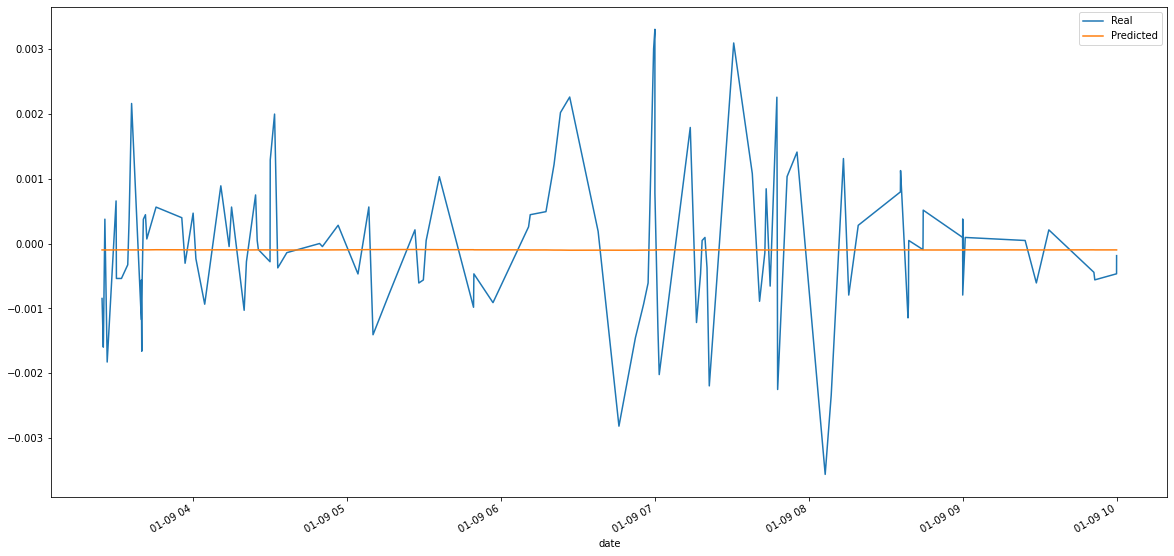

In [102]:
# Plot the real vs predicted prices as a line chart
stocks.plot(figsize=(20,10));

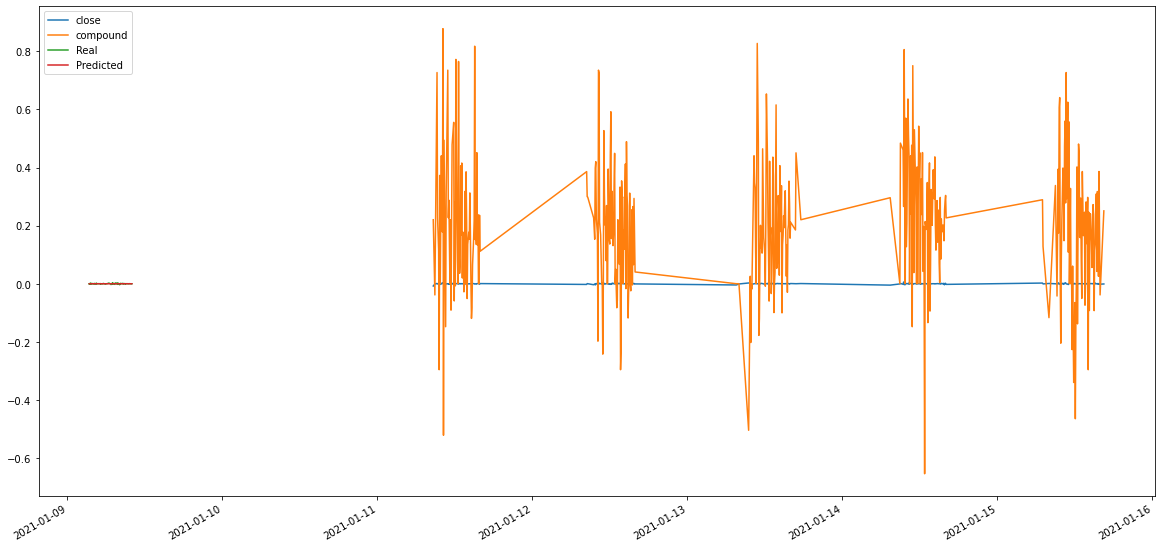

In [103]:
predicted_df = combined_df.append(stocks)
predicted_df.plot(figsize=(20,10));

In [87]:
# Save model as JSON
sentiment_model_json = model.to_json()

file_path = Path("ml_model/sentiment_model.json")
with open(file_path, "w") as json_file:
    json_file.write(sentiment_model_json)

# Save weights
file_path = "ml_model/sentiment_model.h5"
model.save_weights(file_path)

In [88]:
# Load the saved model to make predictions
from tensorflow.keras.models import model_from_json

# load json and create model
file_path = Path("ml_model/sentiment_model.json")
with open(file_path, "r") as json_file:
    sentiment_model_json = json_file.read()
sentiment_loaded_model = model_from_json(sentiment_model_json)

# load weights into new model
file_path = "ml_model/sentiment_model.h5"
sentiment_loaded_model.load_weights(file_path)

In [ ]:
# Make some predictions with the loaded model
predicted_df["predicted"] = sentiment_loaded_model.predict(X)
predicted_df.head(10)